In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Analiza danych o stronach

Wczytajmy dane z pliku i sprawdźmy jak się prezentują

In [11]:
df = pd.read_csv("analytics-bloomington.in.gov-pages-20170101-20170518.csv")
df.head()

,Page,Pageviews,Unique Pageviews,Avg. Time on Page,Entrances,Bounce Rate,% Exit,Page Value
0,/,"199,472","105,537",0:00:23,"95,373",13.56%,20.64%,$0.00
1,/animal-shelter/animals,"164,699","35,458",0:00:14,"13,635",0.12%,6.21%,$0.00
2,/animal-shelter,"90,820","33,427",0:00:16,"28,948",0.34%,12.96%,$0.00
3,/departments/hr/jobs,"88,402","27,365",0:00:18,"18,204",1.33%,17.28%,$0.00
4,/utilities/pay-bill,"79,530","34,706",0:00:30,"18,960",1.39%,40.78%,$0.00


Zauważmy, że dane nie są gotowe do analizy. Trzeba je oczyścić!

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Page               5000 non-null   object
 1   Pageviews          5000 non-null   object
 2   Unique Pageviews   5000 non-null   object
 3   Avg. Time on Page  5000 non-null   object
 4   Entrances          5000 non-null   object
 5   Bounce Rate        5000 non-null   object
 6   % Exit             5000 non-null   object
 7   Page Value         5000 non-null   object
dtypes: object(8)
memory usage: 312.6+ KB


Wszystkie kolumny są wypełnione danymi typu 'object', oczyśćmy dane i zmieńmy ich typ na numeryczny

### Czyszczenie

In [13]:
c_df = df.iloc[:,1:].replace(regex='[\,\$\%\:\<]', value='')
c_df = c_df.astype(float)
c_df.head()

,Pageviews,Unique Pageviews,Avg. Time on Page,Entrances,Bounce Rate,% Exit,Page Value
0,199472.0,105537.0,23.0,95373.0,13.56,20.64,0.0
1,164699.0,35458.0,14.0,13635.0,0.12,6.21,0.0
2,90820.0,33427.0,16.0,28948.0,0.34,12.96,0.0
3,88402.0,27365.0,18.0,18204.0,1.33,17.28,0.0
4,79530.0,34706.0,30.0,18960.0,1.39,40.78,0.0


Dane oczyszczone, możemy przystąpić do analizy

In [14]:
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pageviews          5000 non-null   float64
 1   Unique Pageviews   5000 non-null   float64
 2   Avg. Time on Page  5000 non-null   float64
 3   Entrances          5000 non-null   float64
 4   Bounce Rate        5000 non-null   float64
 5   % Exit             5000 non-null   float64
 6   Page Value         5000 non-null   float64
dtypes: float64(7)
memory usage: 273.6 KB


### Analiza
Sprawdźmy korelację między zmiennymi

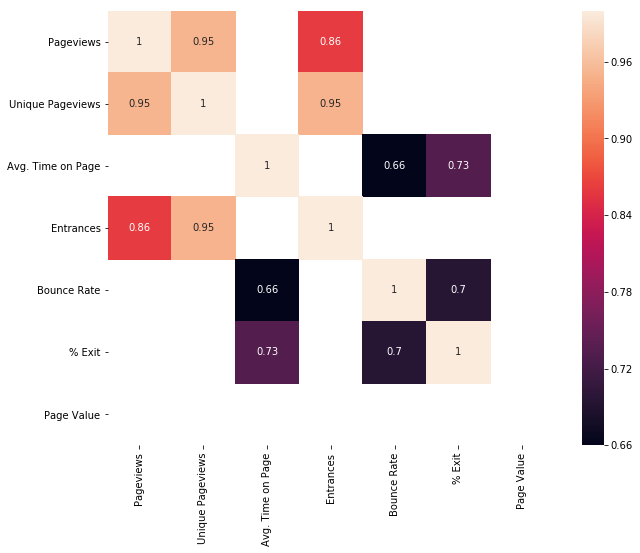

In [15]:
index = c_df.corr()>0.6
plt.figure(figsize=(10,8))
sns.heatmap(c_df.corr()[index], annot=True)
plt.show()

Wygląda na to, że zachodzi silna korelacja między unikalnymi wyświetleniami strony, a zwykłym wyświetlaniem, czego można było się spodziewać. Co ciekawe wygląda na to, że im większy spędzony czas przy stronie tym większy jest % wyjść. 
Następnie zobaczmy jak wyglądają zależności między zmiennymi

<Figure size 720x576 with 0 Axes>

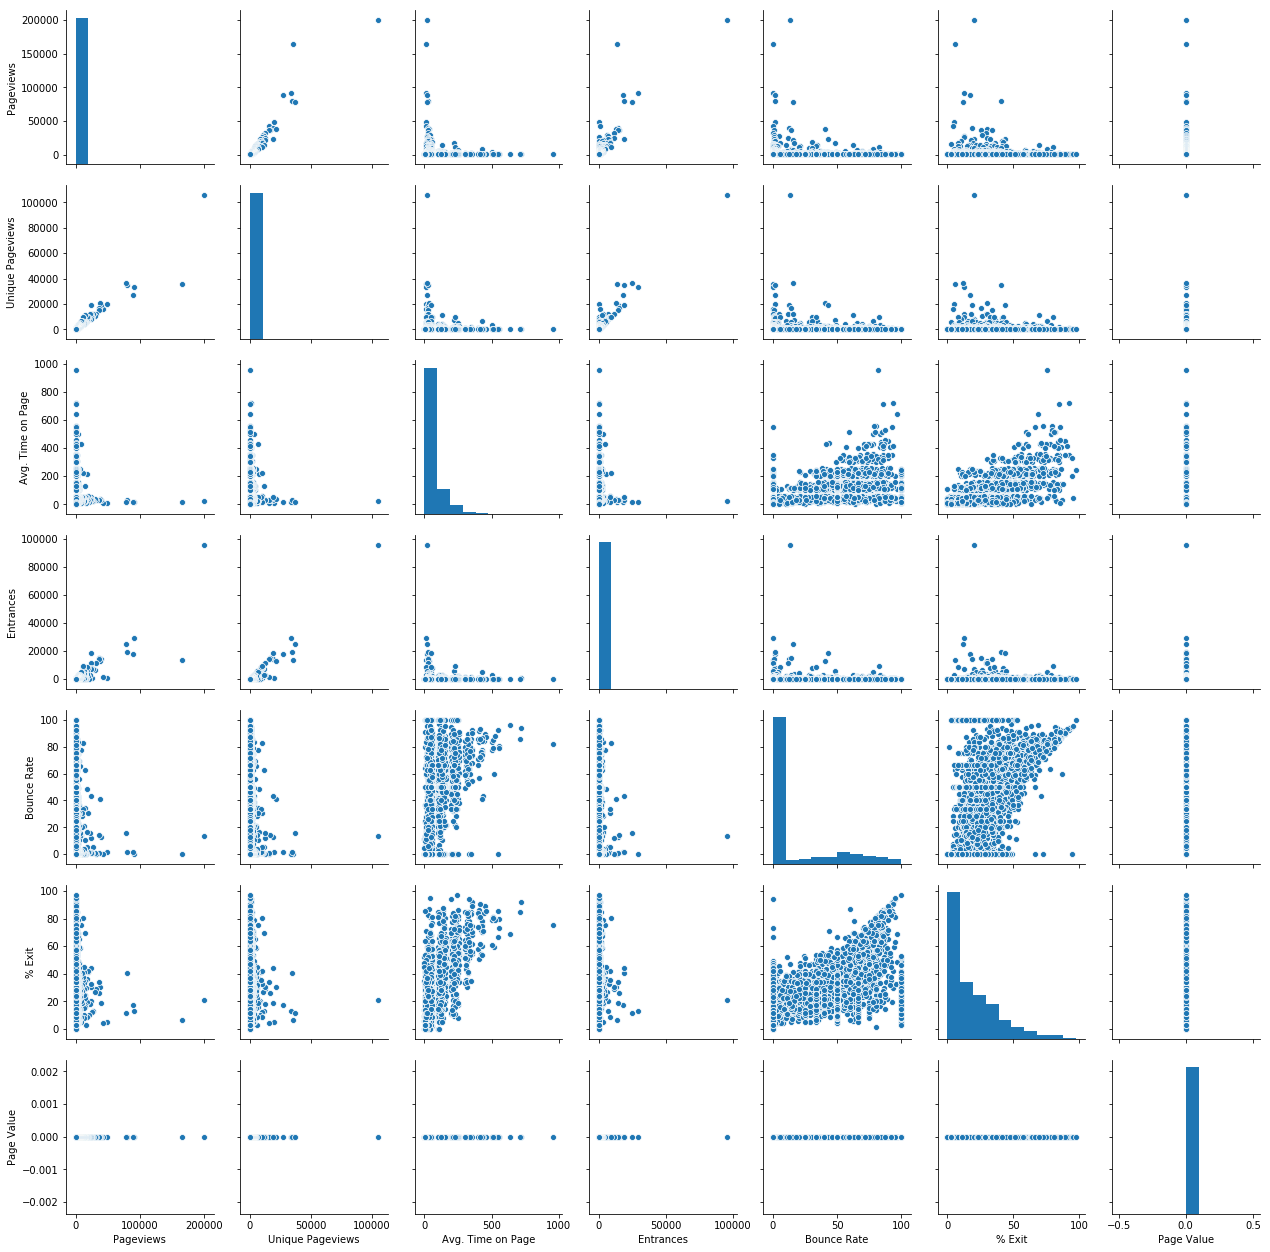

In [52]:
plt.figure(figsize=(10,8))
sns.pairplot(c_df)
plt.show()

Zauważmy, że zależności między Bounce Rate a % Exit oraz Avg. Time on Page skrywają w sobie jakąś funkcję która je determinuje. W związku z tym dla treningu spróbuję stworzyć i nauczyć model drzewa decyzyjnego przewidującego wartość % wyjść.

### Machine learning
Spróbujmy przewidzieć % wyjść ze strony na podstawie danych, które posiadamy

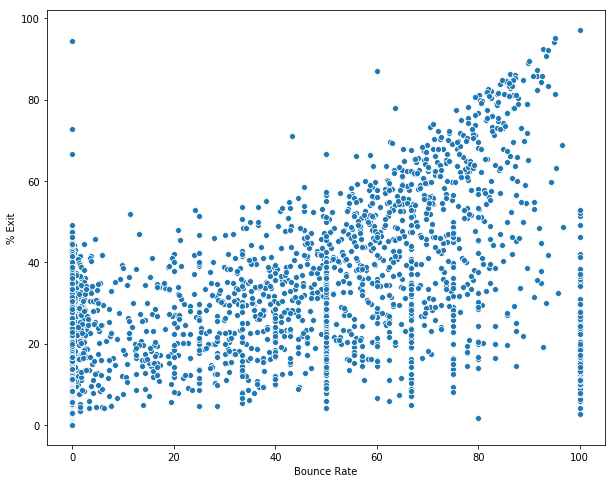

In [20]:
plt.figure(figsize=(10,8))
sns.scatterplot(c_df['Bounce Rate'], c_df['% Exit'])
plt.show()

Stwórzmy i wytrenujmy nasz model

In [51]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

tree = DecisionTreeRegressor()
scaler = StandardScaler()

c_d = c_df.drop('% Exit', axis=1)

X=c_d.values
y=c_df['% Exit'].values

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print("r2_score for testing: " , r2_score(y_test, y_pred))

r2_score for testing:  0.7863217659269802


### Porównanie przewidzianych wyników z prawdziwymi

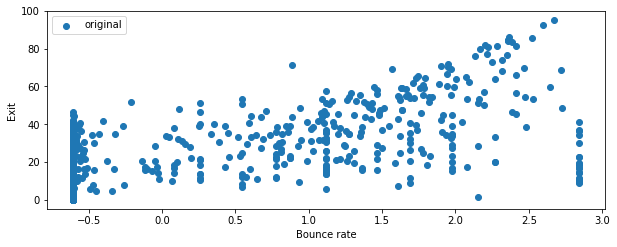

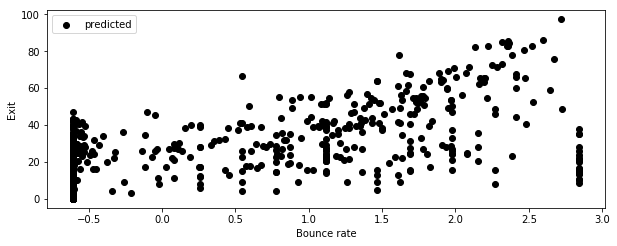

In [28]:
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.scatter(X_test[:,4], y_test, label='original')
plt.xlabel("Bounce rate")
plt.ylabel("Exit")
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,8))
plt.subplot(2, 1, 2)
plt.scatter(X_test[:,4], y_pred, label='predicted', color='black')
plt.xlabel("Bounce rate")
plt.ylabel("Exit")
plt.legend(loc='upper left')
plt.show()

Wygląda na to ,że nasz model całkiem dobrze przewidział wynik na podstawie testowych danych!